In [1]:
import stim 
import numpy as np
import networkx as nx
from css import *
from graphs import edge_coloring
edge_color_bipartite = edge_coloring.edge_color_bipartite

In [2]:
sfcode3 = SurfaceCode(d=3)
sfcode3.H_X, sfcode3.H_Z

(array([[1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1]], dtype=uint8),
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=uint8))

In [3]:
sfcode3.L_X, sfcode3.L_Z
#Notice that Lz is diagonal 

(array([[0, 0, 0, 0, 0, 0, 1, 1, 1]], dtype=uint8),
 array([[1, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=uint8))

In [4]:
from sec_circuits.sec_static import stim_circuit_from_checks as stim_circuit_from_checks

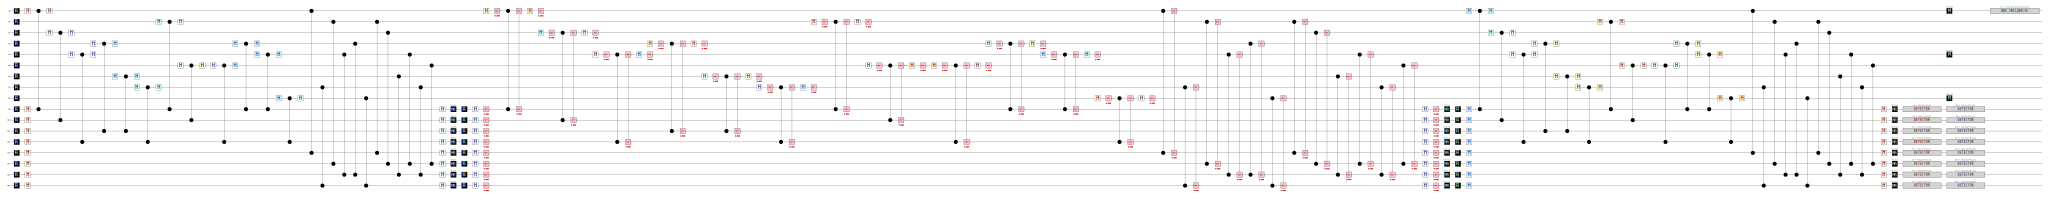

In [5]:
Hx = sfcode3.H_X
Hz = sfcode3.H_Z
Lx = sfcode3.L_X
Lz = sfcode3.L_Z
circuit = stim_circuit_from_checks(Hx, Hz, logical_obs_qubits=Lz, num_rounds=1, p1=0.003, p2=0.003)
circuit.diagram("timeline-svg")

In [6]:
import pymatching

d = 7
sfcode = SurfaceCode(d=d)
Hx = sfcode.H_X
Hz = sfcode.H_Z
Lx = sfcode.L_X
Lz = sfcode.L_Z
noise = 0.001
circuit = stim_circuit_from_checks(
            Hx,
            Hz,
            logical_obs_qubits=Lz,
            num_rounds=d * 3,
            p1=noise,
            p2=noise,
        )

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
sampler = circuit.compile_detector_sampler()
syndrome, actual_observables = sampler.sample(shots=100000, separate_observables=True)

In [7]:
num_errors = 0
for i in range(syndrome.shape[0]):
    predicted_observables = matching.decode(syndrome[i, :])
    num_errors += not np.array_equal(actual_observables[i, :], predicted_observables)

print(num_errors)  # prints 8

75


In [9]:
import matplotlib.pyplot as plt
def run_threshold(
    code_type="surface",  # or "toric"
    distances=[3, 5, 7, 9], 
    noise_rates=[0.001, 0.005, 0.009, 0.013], 
    shots=10000
):
    """Run threshold simulation for either surface or toric code.
    
    Args:
        code_type: Either "surface" or "toric" to specify code type
        distances: List of code distances to test
        noise_rates: List of physical error rates to test
        shots: Number of shots to sample for each configuration
        
    Returns:
        Tuple of (distances, noise_rates, logical_error_rates)
    """
    # Store results: logical_error_rates[d_idx][noise_idx]
    logical_error_rates = np.zeros((len(distances), len(noise_rates)))
    
    for d_idx, d in enumerate(distances):
        print(f"Running distance d={d}...")
        
        # Initialize appropriate code
        if code_type == "surface":
            code = SurfaceCode(d=d)
        elif code_type == "toric":
            code = ToricCode(d=d)
        else:
            raise ValueError(f"Unknown code_type: {code_type}")
            
        Hx = code.H_X
        Hz = code.H_Z
        Lx = code.L_X
        Lz = code.L_Z
        
        for noise_idx, noise in enumerate(noise_rates):
            print(f"  Testing noise rate p={noise:.3f}...")
            
            # Create circuit
            circuit = stim_circuit_from_checks(
                Hx,
                Hz,
                logical_obs_qubits=Lz,
                num_rounds=d * 3,  
                p1=noise,
                p2=noise,
            )
            
            # Create matching model
            model = circuit.detector_error_model(decompose_errors=True)
            matching = pymatching.Matching.from_detector_error_model(model)
            
            # Sample and decode
            sampler = circuit.compile_detector_sampler()
            syndrome, actual_observables = sampler.sample(shots=shots, separate_observables=True)
            
            # Decode and count errors
            predicted_observables = matching.decode_batch(syndrome)
            errors = np.any(predicted_observables != actual_observables, axis=1)
            error_rate = np.mean(errors)
            
            logical_error_rates[d_idx, noise_idx] = error_rate
            print(f"    Logical error rate: {error_rate:.4f}")
    
    return distances, noise_rates, logical_error_rates


In [10]:
# Run the surface code memory experiment
distances, noise_rates, logical_error_rates = distances, noise_rates, logical_error_rates = run_threshold(code_type="surface",
    distances=[3, 5, 7, 9], 
    noise_rates=[0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013], 
    shots=10000)


Running distance d=3...
  Testing noise rate p=0.001...
    Logical error rate: 0.0543
  Testing noise rate p=0.003...
    Logical error rate: 0.1546
  Testing noise rate p=0.005...
    Logical error rate: 0.2262
  Testing noise rate p=0.007...
    Logical error rate: 0.2969
  Testing noise rate p=0.009...
    Logical error rate: 0.3605
  Testing noise rate p=0.011...
    Logical error rate: 0.3927
  Testing noise rate p=0.013...
    Logical error rate: 0.4124
Running distance d=5...
  Testing noise rate p=0.001...
    Logical error rate: 0.0047
  Testing noise rate p=0.003...
    Logical error rate: 0.0406
  Testing noise rate p=0.005...
    Logical error rate: 0.1216
  Testing noise rate p=0.007...
    Logical error rate: 0.2392
  Testing noise rate p=0.009...
    Logical error rate: 0.3362
  Testing noise rate p=0.011...
    Logical error rate: 0.4104
  Testing noise rate p=0.013...
    Logical error rate: 0.4582
Running distance d=7...
  Testing noise rate p=0.001...
    Logical er

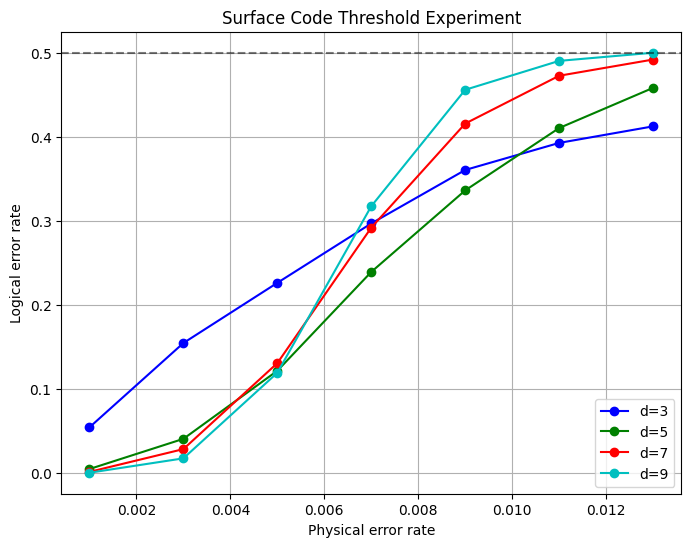

In [11]:
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c']

for d_idx, d in enumerate(distances):
	plt.plot(noise_rates, logical_error_rates[d_idx], 
				'o-', color=colors[d_idx], label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Surface Code Threshold Experiment')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Run the toric code memory experiment
distances, noise_rates, logical_error_rates = distances, noise_rates, logical_error_rates = run_threshold(code_type="toric",
    distances=[3, 5, 7, 9], 
    noise_rates=[0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013], 
    shots=10000)


Running distance d=3...
  Testing noise rate p=0.001...
    Logical error rate: 0.0058
  Testing noise rate p=0.003...
    Logical error rate: 0.0554
  Testing noise rate p=0.005...
    Logical error rate: 0.1538
  Testing noise rate p=0.007...
    Logical error rate: 0.2603
  Testing noise rate p=0.009...
    Logical error rate: 0.3430
  Testing noise rate p=0.011...
    Logical error rate: 0.4214
  Testing noise rate p=0.013...
    Logical error rate: 0.4561
Running distance d=5...
  Testing noise rate p=0.001...
    Logical error rate: 0.0005
  Testing noise rate p=0.003...
    Logical error rate: 0.0289
  Testing noise rate p=0.005...
    Logical error rate: 0.1303
  Testing noise rate p=0.007...
    Logical error rate: 0.2852
  Testing noise rate p=0.009...
    Logical error rate: 0.4197
  Testing noise rate p=0.011...
    Logical error rate: 0.4810
  Testing noise rate p=0.013...
    Logical error rate: 0.4939
Running distance d=7...
  Testing noise rate p=0.001...
    Logical er

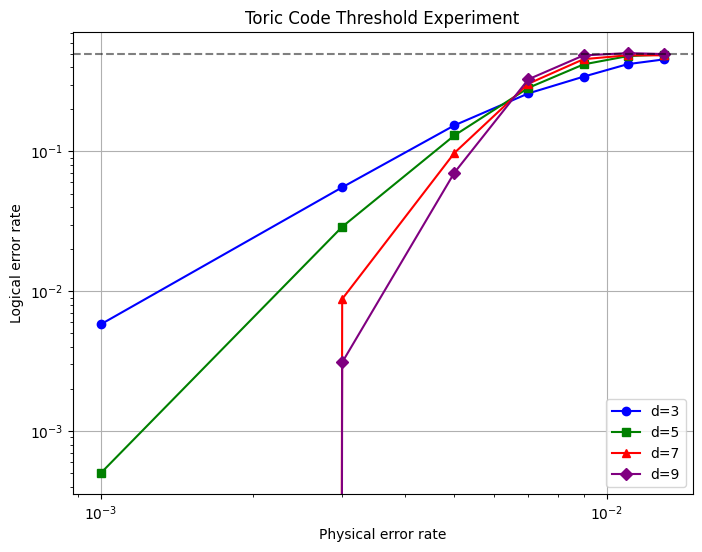

In [13]:
plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D']
colors = ['b', 'g', 'r', 'purple']
for d_idx, d in enumerate(distances):
	plt.plot(noise_rates, logical_error_rates[d_idx], 
				marker=markers[d_idx], color=colors[d_idx], label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Toric Code Threshold Experiment')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.show()

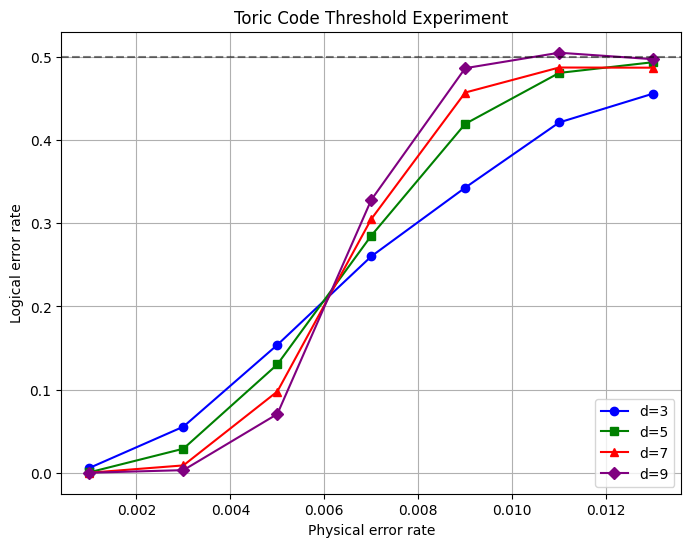

In [14]:
plt.figure(figsize=(8, 6))
markers = ['o', 's', '^', 'D']
colors = ['b', 'g', 'r', 'purple']
for d_idx, d in enumerate(distances):
	plt.plot(noise_rates, logical_error_rates[d_idx], 
				marker=markers[d_idx], color=colors[d_idx], label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Toric Code Threshold Experiment')
plt.legend()
plt.grid(True)

plt.show()